# Análise de Risco de Crédito com Otimização de Hiperparâmetros 🏦

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('german_credit_data.csv')

In [3]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [5]:
df = df.drop('Unnamed: 0', axis=1)

<Axes: xlabel='Risk', ylabel='count'>

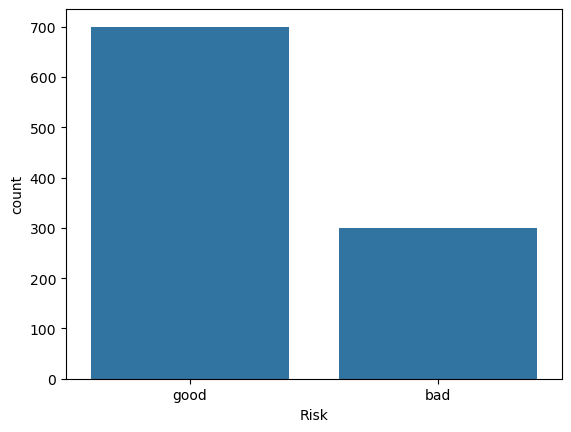

In [6]:
sns.countplot(x='Risk', data=df)

In [7]:
df['Risk'] = df['Risk'].map({'good': 0, 'bad':1})

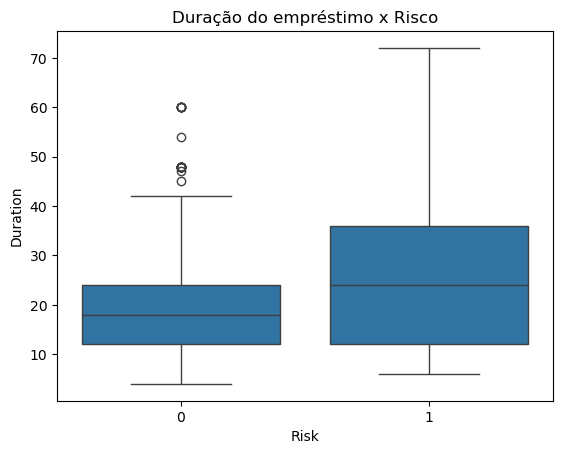

In [8]:
sns.boxplot(x='Risk', y='Duration', data=df)
plt.title('Duração do empréstimo x Risco')
plt.show()

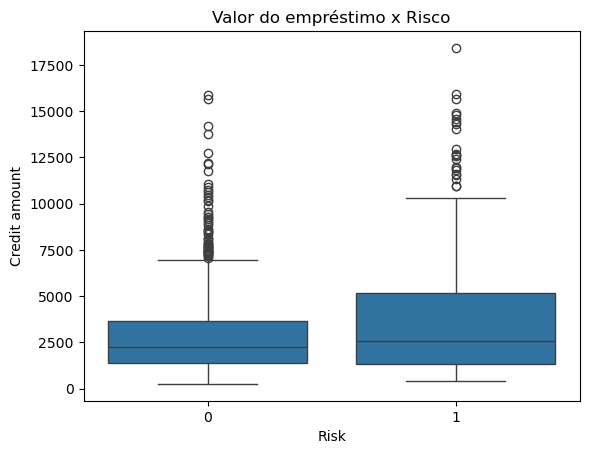

In [9]:
sns.boxplot(x='Risk', y='Credit amount', data=df)
plt.title('Valor do empréstimo x Risco')
plt.show()

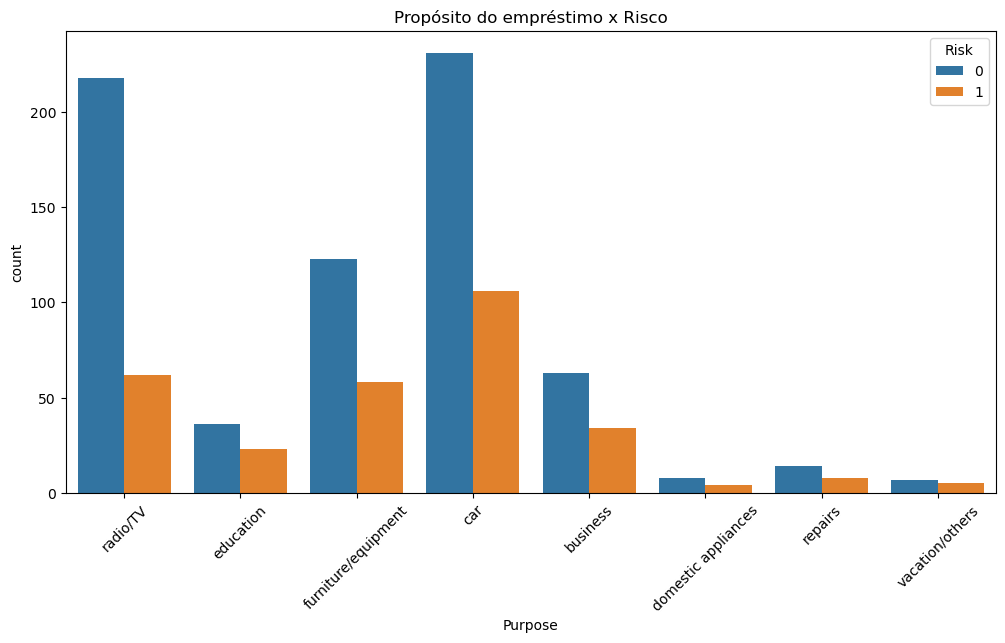

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Purpose', hue='Risk', data=df)
plt.xticks(rotation=45)
plt.title('Propósito do empréstimo x Risco')
plt.show()

In [11]:
y = df['Risk']
x = df.drop('Risk', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [13]:
features_numericas = x.select_dtypes(include=['int64', 'float64']).columns
features_categoricas = x.select_dtypes(include=['object']).columns

In [14]:
pipeline_numerico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

pipeline_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', pipeline_numerico, features_numericas),
        ('cat', pipeline_categorico, features_categoricas)
    ])

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [16]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])


param_grid = {
    'classifier__n_estimators': [100, 200],      # Testar com 100 e 200 árvores
    'classifier__max_depth': [10, 20, None],    # Testar profundidade 10, 20 e sem limite
    'classifier__min_samples_split': [2, 5]     # Testar com mínimo de 2 e 5 amostras para dividir
}


grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='recall', verbose=1)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'Job', 'Credit amount', 'Duration'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='recall', verbose=1)

In [17]:
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

print("\nMelhor score de recall (validação cruzada):")
print(f"{grid_search.best_score_:.2f}")


Melhores parâmetros encontrados:
{'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Melhor score de recall (validação cruzada):
0.35


In [18]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [19]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
print("--- Relatório de Classificação do Modelo Otimizado (no Conjunto de Teste) ---")
print(classification_report(y_test, y_pred))

--- Relatório de Classificação do Modelo Otimizado (no Conjunto de Teste) ---
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       210
           1       0.45      0.36      0.40        90

    accuracy                           0.68       300
   macro avg       0.60      0.58      0.59       300
weighted avg       0.66      0.68      0.66       300




--- Matriz de Confusão ---


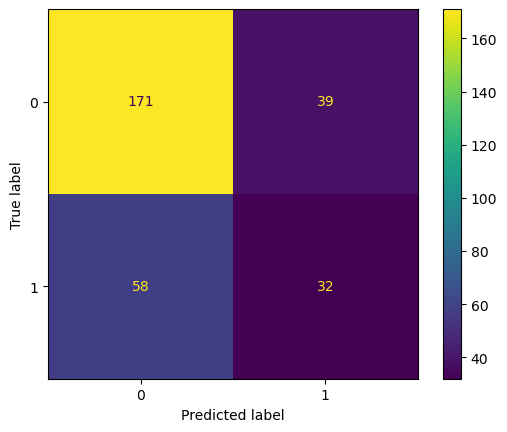

In [20]:
print("\n--- Matriz de Confusão ---")
ConfusionMatrixDisplay.from_estimator(best_model, x_test, y_test)
plt.show();

# ✅ Conclusão Final do Projeto

Este projeto abordou o desafio de **análise de risco de crédito**, utilizando técnicas avançadas de Machine Learning para construir um modelo preditivo robusto. O foco principal foi a aplicação de **Pipelines** para um pré-processamento seguro e a **otimização de hiperparâmetros com `GridSearchCV`** para extrair a melhor performance possível.

### Resumo do Processo

1.  **Pré-processamento com Pipelines:** Foi construído um pipeline completo com `ColumnTransformer` para tratar de forma automática e segura os dados faltantes, as variáveis categóricas (com `OneHotEncoder`) e as numéricas (com `StandardScaler`).

2.  **Otimização de Hiperparâmetros:** Utilizou-se o `GridSearchCV` para testar sistematicamente várias combinações de hiperparâmetros do modelo `RandomForestClassifier` (como `n_estimators`, `max_depth`, etc.). O objetivo da busca foi otimizar a métrica **`recall`**, crucial para problemas de risco, onde é mais importante identificar os casos de "mau" risco.

3.  **Avaliação Final:** O melhor modelo encontrado pelo `GridSearchCV` foi então avaliado no conjunto de teste, que permaneceu intocado durante todo o processo de treinamento e otimização.

### Resultados e Performance

O modelo otimizado apresentou os seguintes resultados no conjunto de teste para a classe de interesse (`Risk = 1`, clientes de "mau" risco):

*   🎣 **Recall de 36%:** O modelo foi capaz de identificar corretamente **36% de todos os clientes que de fato representavam um risco** de não pagamento.
*   🎯 **Precisão de 45%:** Quando o modelo sinaliza um cliente como "de risco", ele está correto 45% das vezes.

**Conclusão Final:**
Apesar da complexidade do problema, o pipeline construído estabelece um *baseline* sólido. Um recall de 36% significa que o modelo já fornece um valor de negócio tangível, permitindo ao banco identificar mais de um terço dos empréstimos problemáticos de forma proativa.

A performance poderia ser melhorada em iterações futuras com **engenharia de features** mais avançada ou testando algoritmos mais potentes para dados desbalanceados, como o **XGBoost com `scale_pos_weight`**. Este projeto serviu como uma excelente demonstração prática do fluxo de trabalho de otimização de modelos, uma das tarefas mais importantes de um Cientista de Dados.